In [1]:
import tensorflow as tf
from keras.layers import Conv2D, BatchNormalization, Activation
from keras.layers import Add, Input, Dense, GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model
from keras.utils import plot_model
from keras.datasets import cifar10

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 22s 0us/step


In [3]:
X_train.shape

(50000, 32, 32, 3)

In [13]:
X_test.shape

(10000, 32, 32, 3)

**Create Identity Block**

The identity block is used to add residual connection to the network without changing the dimension of the input. It consists of two Convolutional layers with BatchNormalization and ReLU activation.

In [4]:
from os import path
def identity_block(x, filters):
    f1, f2 = filters

    x_shortcut = x

    # first component of mian path
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second component of main path
    x = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    # Add shotcut value to the main path
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    return x

**Convolutional Block** \
It consists of two convolutional layers with BatchNormalization and ReLU activation, and additional convolutional layer for layer for the shortcut connection to match dimensions.

In [5]:
def convolutional_block(x, filters, s=2):
    f1, f2 = filters

    x_shortcut = x

    # first component of main path
    x = Conv2D(f1, kernel_size=(3, 3), strides=(s, s), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second component of main path
    x = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    # shortcut path
    x_shortcut = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='same')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)

    # Add shotcut value to the main path
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    return x


**Create the ResNet Archietucture**


In [6]:
def ResNet(input_shape, num_classes=10):
    inputs = Input(shape= input_shape)

    # Stage 1
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Stage 2
    x = convolutional_block(x, filters=[64, 64], s=1)
    x = identity_block(x, filters=[64, 64])

    # Stage 3
    x = convolutional_block(x, filters=[128, 128], s=2)
    x = identity_block(x, filters=[128, 128])

    # Stage 4
    x = convolutional_block(x, filters=[256, 256], s=2)
    x = identity_block(x, filters=[256, 256])

    # Stage 5
    x = convolutional_block(x, filters=[512, 512], s=2)
    x = identity_block(x, filters=[512, 512])

    # Average Pooling
    x = GlobalAveragePooling2D()(x)

    # output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # create model
    model = Model(inputs, outputs)
    return model

In [7]:
model = ResNet((32, 32, 3), 10)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 16, 16, 64)           0         ['batch_normalization[0][0

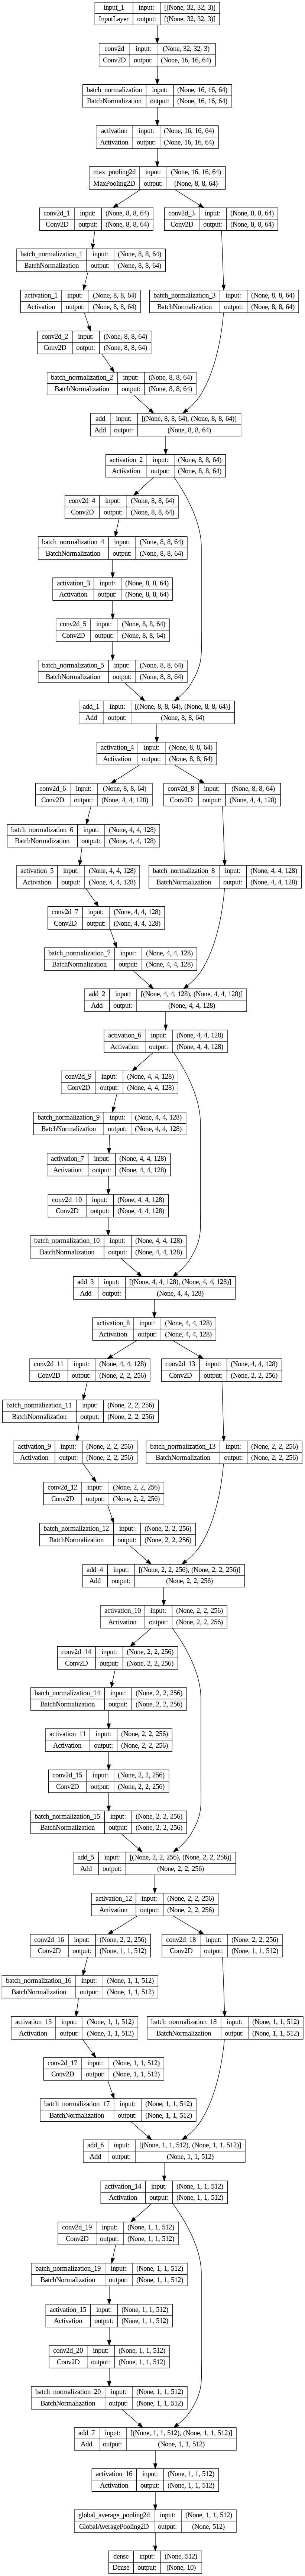

In [9]:
plot_model(model, show_shapes=True)

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(X_train, y_train, epochs=5, batch_size=10)

Epoch 1/5
5000/5000 [==============================] - 108s 18ms/step - loss: 1.7541 - accuracy: 0.3916
Epoch 2/5
5000/5000 [==============================] - 91s 18ms/step - loss: 1.2745 - accuracy: 0.5609
Epoch 3/5
5000/5000 [==============================] - 91s 18ms/step - loss: 1.0329 - accuracy: 0.6425
Epoch 4/5
5000/5000 [==============================] - 90s 18ms/step - loss: 0.8678 - accuracy: 0.7044
Epoch 5/5
5000/5000 [==============================] - 102s 20ms/step - loss: 0.7425 - accuracy: 0.7458


In [14]:
model.evaluate(X_test, y_test, batch_size= 1)

10000/10000 [==============================] - 57s 6ms/step - loss: 0.9712 - accuracy: 0.6707


[0.9712282419204712, 0.6707000136375427]